# Supplementary Source Code 6 – Crop-Environment Growth Analysis

This jupyter notebook explores the interactions between data collected about five different wheat genotypes and corresponding daily environmental data. Correlations between the environmental features and growth are explored. A global model is produced from all five genotypes to estimate crop growth from the selected environmental factors captured by the CropQuant platform. The algorithm and associated libraries produced for forecasting crop growth at different key growth stages which incorporates crop genotypes, environmental factors, and growth related traits measured by SC4-CropTraitMeasuring_PC_V1.15. Using the Notebook, we provide an interactive computational environment that facilitates libraries imports, tailored functions, machine learning based modelling and prediction outputs for future users to: 

* Execute codes and associated mathematical models
* Generate plots and intermediate processing results  
* Process phenotypic and environment datasets to predict wheat growth at differnt stages. 

## Please note that:  
* A Jupyter notebook is ONLY used for demonstrating the algorithm, NOT for batch processing big crop image series.
* The performance of the algorithm provided for the CropQuant breeding project could be varied due to an end-user's computing resources such as physical memory and CPU speed.
* Users might encounter issues with specific libraries if they have not installed properly or not been optimised for Linux-based operating systems.
* We recommend users to preinstall the latest open Anaconda Python distribution before using functions and modules in the CropQuant analysis pipeline that requires Scikit-image or Scikit-learning functions. 


In [1]:
#################################################################
#                                                               #
#    Authors: Mr Tom Le-Cornu, Thomas.Le-Cornu@earlham.ac.uk    #
#             Dr Ji Zhou (周济), ji.zhou@earlham.ac.uk           #
#    Date: 24th October 2016                                    #
#                                                               #
#    Version: 0.1 on EI internal Github                         #
#    Stable version: 1.15 on EI internal Github and Bitbcuket   #
#                                                               #
#    Software license: the bespoke CropQuant Software License   #
#    the algorithm below is developed by Dr Zhou and his team,  #
#    which shall only be used for research purpose.             #
#                                                               #
#################################################################

In [2]:
%matplotlib inline

# General imports
import warnings

# Mathematical and scientific imports
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
from pandas.stats.moments import rolling_mean

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
from matplotlib import cm
from matplotlib import rcParams

# Machine learning imports
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics

## Read Crop-Climate data

In [3]:
# Define a function for calculating the correlation of two sets of variables.
rcorr = lambda x, y: pearsonr(x, y)[0]

# Set plotting style and fontsize.
sns.set(font_scale=1.4, style="whitegrid")

# Filter warnings. Required as updated pandas module throws lots of errors, 
# but still supports the functions...
warnings.filterwarnings('ignore')

In [4]:
# Read a csv file contains both phenotypic, genotypic and environmental data
csv_file = "./CropEnv_Ref_NEW.csv"

In [5]:
def p2f(x):
    """ Converts a string containing a percent sign into a float value. """
    return float(x.strip('%')) / 100.

The .csv file is read and processing performed on the percent columns and column titles to ensure issues don't occur in the rest of the notebook.

In [6]:
df = pd.read_csv(csv_file, index_col=0, converters={'RGR' : p2f})
df.columns = [col.strip() for col in df.columns]
df[:5]

,Real_Height,Nom_DegDay_May,Acc_DegDay,ThermU_Day,Avg_Temp,SolarRadi_Day,Light_Dur_Day,AVG_LightInt_Day,Rain,Wind,RGR,GS_Days,Genotype,Grow_Stg
ID,,,,,,,,,,,,,,
1,20.6,51,1269,9.7,10.9,7.5,14.8,95.63,3.0,19,NaN,-24,G1,1
2,23.2,63,1280,11.4,10.5,6.1,15.4,83.16,3.3,15,0.1262,-23,G1,1
3,21.5,69,1286,6.1,13.3,3.6,15.6,84.54,0.0,32,-0.0733,-22,G1,1
4,24.4,86,1303,16.9,10.8,9.2,15.4,89.83,0.0,18,0.1349,-21,G1,1
5,25.8,98,1315,11.9,15.6,8.0,16.1,86.88,0.0,29,0.0574,-20,G1,1


The starting height values for each of the genotypes is extracted for use as the starting points for each genotype in the global model.

In [7]:
start_values = df.iloc[np.isnan(df['RGR']).nonzero()]

The input columns from the CSV are as follows:
* ID: data points during the season 
* Real_Height: crop height
* Nom_DegDay_May: Normalised Degree Day from 1st of May
* Acc_DegDay: Accumulated Degree Day reading (this is the same data series with Nom_DegDay_May, biologically this factor should be used in the analysis) 
* ThermU_Day: Thermal units received per day
* Avg_Temp: Average temperature per day
* SolarRadi_Day: Average solar radiation per day
* Light_Dur_Day: light duration per day
* AVG_LightInt_Day: Average light intensity per day
* Rain: Average rainfall per day 
* Wind: wind gushing per day
* RGR: relative growth rate per day 
* GS_Days: accumulated days within one growth stage (as we have not monitored from the stem elongation, hence for the Growth Stage 1, the counting is reversed) 
* Genotype: genotypes used for the experiments, GT stands for the overall paragon background, which provides the overall view of all genotypes we are testing. 
* Grow_Stg: 1 (stem elongation) - 6 (physical maturity) 

Preprocessing of the data is performed:
* Remove columns with NaN values (first value of relative growth rate)
* Extract required columns that don't make up the environmental features
* Drop those columns we extracted in the previous step

In [8]:
df_copy = df.dropna()

y_real_height = df_copy['Real_Height']
y_rel_growth_rate = df_copy['RGR']
grow_stage = df_copy['Grow_Stg']
genotype = df_copy['Genotype']

features = df_copy.drop(['Real_Height', 'RGR', 'Grow_Stg', 'Genotype'], axis=1)
orig_feas = features.copy()

In [9]:
stages = range(1, 7)

# Below is used for ignoring the Genotype Total features.
ignore = np.logical_not(genotype == 'GT') 

In [10]:
features[:5]

,Nom_DegDay_May,Acc_DegDay,ThermU_Day,Avg_Temp,SolarRadi_Day,Light_Dur_Day,AVG_LightInt_Day,Rain,Wind,GS_Days
ID,,,,,,,,,,
2,63,1280,11.4,10.5,6.1,15.4,83.16,3.3,15,-23
3,69,1286,6.1,13.3,3.6,15.6,84.54,0.0,32,-22
4,86,1303,16.9,10.8,9.2,15.4,89.83,0.0,18,-21
5,98,1315,11.9,15.6,8.0,16.1,86.88,0.0,29,-20
6,104,1322,6.5,13.9,8.0,15.9,85.38,0.7,29,-19


In [11]:
for geno in start_values.Genotype.tolist():
    mask = df.Genotype == geno
    
    # Add the cumulative rain column for each genotype
    if 'Acc_Rain' not in features.columns:
        features['Acc_Rain'] = features[mask].Rain.cumsum()
    else:
        features.loc[mask, 'Acc_Rain'] = features[mask].Rain.cumsum()

Select the features we are interested in using.

In [12]:
features = features[['Acc_DegDay', 'Avg_Temp', 'Light_Dur_Day', 'AVG_LightInt_Day', 'Acc_Rain']]
print features[:10]

    Acc_DegDay  Avg_Temp  Light_Dur_Day  AVG_LightInt_Day  Acc_Rain
ID                                                                 
2         1280      10.5           15.4             83.16       3.3
3         1286      13.3           15.6             84.54       3.3
4         1303      10.8           15.4             89.83       3.3
5         1315      15.6           16.1             86.88       3.3
6         1322      13.9           15.9             85.38       4.0
7         1334       9.7           14.6             81.87       4.0
8         1345       7.0           16.1             80.13       4.0
9         1353      10.6           15.9             88.68       4.0
10        1359      13.5           16.1             83.93       4.0
11        1371      10.0           14.6             82.86       6.5


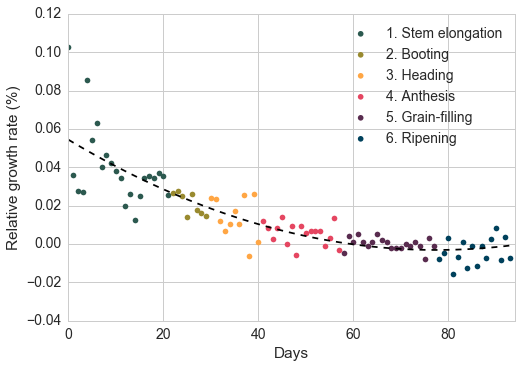

In [13]:
# Plot the relative growth rate for the mean of the genotypes to gain intuition 
# as to how it varies over time. Stages are coloured individually.
fig, ax = plt.subplots(1, 1)

gt_y_rgr = y_rel_growth_rate[genotype == 'GT']

cc = ColorConverter()

colours = [    
    cc.to_rgb('#2C594F'),
    cc.to_rgb('#998A2F'), 
    cc.to_rgb('#FFA644'),
    cc.to_rgb('#E54661'),
    cc.to_rgb('#592C4F'), 
    cc.to_rgb('#00415C'), 
]

labels = [
    '1. Stem elongation',
    '2. Booting',
    '3. Heading',
    '4. Anthesis',
    '5. Grain-filling',
    '6. Ripening'
]

ctr = 0
for st in stages:
    idx = st - 1
    retain = grow_stage == st
    
    # Get the relative growth rate for each stage
    y = y_rel_growth_rate[genotype == geno][retain].as_matrix()
    
    # Get x follows for curve fitting
    x = np.arange(ctr, ctr + y.shape[0])
    ctr += y.shape[0]
    
    # Plot the RGRs
    ax.scatter(x, y, c=colours[idx], label=labels[idx], s=32, lw=0)

ax.legend(loc="upper right")
plt.xlabel("Days")
plt.ylabel("Relative growth rate (%)")
plt.xlim([0, 94])

def func(X, a, b, c):
    """ Second-order polynomial function. """
    return ((X ** 2) * a) + (X * b) + c

# Perform curve fitting to produce line of best fit
p_opt, _ = curve_fit(func, np.arange(94), gt_y_rgr)
gt_rgr_pred = func(np.arange(94), *p_opt)
plt.plot(gt_rgr_pred, 'k--')

# Uncomment below to save the figure
#fig.savefig("rgr-scatter-total-genotype-lob.png", dpi=300)

Same plot as above but for all of the genotypes. Looks considerably messier.

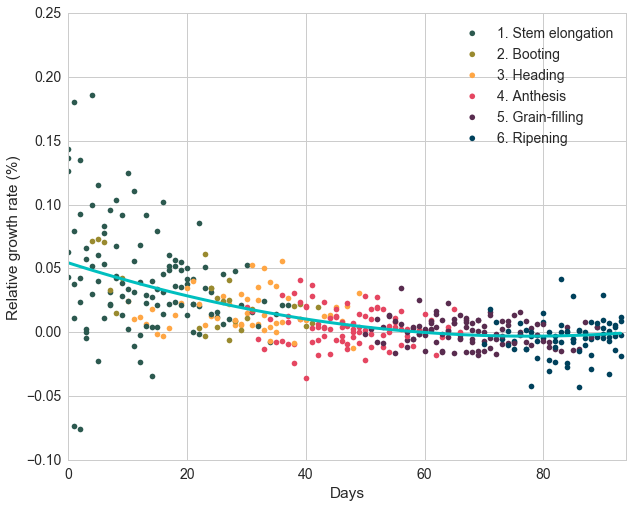

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10., 8.)) 

# Same as above plot but plotting all of the relative growth rates for the 
# five genotypes.
done_labels = False
for geno in start_values.Genotype.tolist():
    if geno == "GT":
        continue
    
    ctr = 0
    for st in range(1, 7):
        idx = st - 1 
        
        # Get the current stage RGR for this genotype
        retain = grow_stage == st
        retain = retain.as_matrix()
        y = y_rel_growth_rate[retain][genotype == geno].as_matrix()
        
        x = np.arange(ctr, ctr + y.shape[0])
        ctr += y.shape[0]
        
        # Only add the labels for the first stage occurence of all the genotypes.
        if done_labels:
            ax.scatter(x, y, c=colours[idx], s=32, lw=0)
        else:
            ax.scatter(x, y, c=colours[idx], s=32, lw=0, label=labels[idx])
            
    done_labels = True
    
legend = ax.legend(loc='upper right', shadow=True)

plt.xlabel("Days")
plt.ylabel("Relative growth rate (%)")
plt.xlim([0, 94])
plt.plot(gt_rgr_pred, 'c-', linewidth=3)

# Uncomment below to save the figure
#fig.savefig("rgr-scatter-all-genotypes-lob.png", dpi=300)

Briefly explore the effect of introducing a n-day lag into correlations between the relative growth rate and environmental features to see if phenomena recorded on a particular day may have more of an effect in the days to come.

## Explore 3-days window

Features to use:
* Accum ThermUnit
* Average ThermUnit
* Average temp
* Accum SolarRadi
* Average SolarRadi
* Average LightDuration
* Average LightIntensity
* Accum Rainfall
* Average wind
* GS Days

In [15]:
feas_3days = df_copy.drop(['Real_Height', 'RGR', 'Grow_Stg', 'Genotype'], axis=1)
feas_3days[:10]

,Nom_DegDay_May,Acc_DegDay,ThermU_Day,Avg_Temp,SolarRadi_Day,Light_Dur_Day,AVG_LightInt_Day,Rain,Wind,GS_Days
ID,,,,,,,,,,
2,63,1280,11.4,10.5,6.1,15.4,83.16,3.3,15,-23
3,69,1286,6.1,13.3,3.6,15.6,84.54,0.0,32,-22
4,86,1303,16.9,10.8,9.2,15.4,89.83,0.0,18,-21
5,98,1315,11.9,15.6,8.0,16.1,86.88,0.0,29,-20
6,104,1322,6.5,13.9,8.0,15.9,85.38,0.7,29,-19
7,117,1334,12.4,9.7,9.7,14.6,81.87,0.0,16,-18
8,127,1345,10.7,7.0,0.1,16.1,80.13,0.0,19,-17
9,136,1353,8.2,10.6,5.1,15.9,88.68,0.0,15,-16
10,142,1359,6.6,13.5,6.4,16.1,83.93,0.0,15,-15


In [16]:
def rolling_window(a, window):
    """ Produce groups of size 'window' of the input array 'a'. """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [29]:
def get_rgr(a, N):
    """ Return the relative growth rate of an N day lag as a set of per cent values. """
    return (a[N:] - a[:-N]) / a[:-N]

In [28]:
geno = 'GT'

geno_real_height = df[df.Genotype == geno].Real_Height.as_matrix()
geno_rgr3 = get_rgr(geno_real_height, 3)

geno_features = feas_3days[genotype == geno]

# Extract the summed 3-day rolling features
ThermU_Day_Sum3 = rolling_window(geno_features.ThermU_Day, 3).sum(axis=1).cumsum()
SolarRadi_Day_Sum3 = rolling_window(geno_features.SolarRadi_Day, 3).sum(axis=1).cumsum()
Rain_Sum3 = rolling_window(geno_features.Rain, 3).sum(axis=1).cumsum()

# Extract the aerage 3-day rolling features
ThermU_Day_Avg3 = rolling_mean(geno_features.ThermU_Day, 3)[2:]
Avg_Temp_Avg3 = rolling_mean(geno_features.Avg_Temp, 3)[2:]
Light_Dur_Day_Avg3 = rolling_mean(geno_features.Light_Dur_Day, 3)[2:]
AVG_LightInt_Day_Avg3 = rolling_mean(geno_features.AVG_LightInt_Day, 3)[2:]

GS_Days_normal = geno_features.GS_Days.as_matrix()[2:]

# Lists for storing correlations for each environmental feature at each stage.
rgr_rcorrs_3day = []
rh_rcorrs_3day = []

for st in range(1, 5):
    mask = (df.Grow_Stg == st)[df.Genotype == geno][3:].as_matrix()

    # Build feature vector from required environmental features
    currX = np.vstack([
            ThermU_Day_Sum3[mask],
            SolarRadi_Day_Sum3[mask],
            Rain_Sum3[mask],
            #ThermU_Day_Avg3[mask],
            Avg_Temp_Avg3[mask],
            Light_Dur_Day_Avg3[mask],
            #AVG_LightInt_Day_Avg3[mask],
            GS_Days_normal[mask]
        ]).T
    
    # Obtain the correlations between the real-height/RGR and the environmental features.
    rgr_rcorrs_3day.append([rcorr(currX[:, i], (1. / np.exp(geno_rgr3[mask]))) for i in range(currX.shape[1])])
    rh_rcorrs_3day.append([rcorr(currX[:, i], geno_real_height[3:][mask]) for i in range(currX.shape[1])])
    
rgr_rcorrs_3day = np.vstack(rgr_rcorrs_3day)
rh_rcorrs_3day = np.vstack(rh_rcorrs_3day)

In [19]:
colss = [
    'Normalised degree day', #ThermU\_Day\_Sum3', 
    'Daily solar radiation', #SolarRadi\_Day\_Sum3', 
    'Rainfall', #\_Sum3', 
    #'ThermU\_Day\_Avg3', 
    'Normalised temperature', #Avg\_Temp\_Avg3', 
    'Daily light duration', #Light\_Dur\_Day\_Avg3',
    #'AVG_LightInt_Day_Avg3',
    'Growth stage duration', #GS\_Days\_normal'
    ]

In [20]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'sans-serif', 'sans-serif':['Helvetica']})

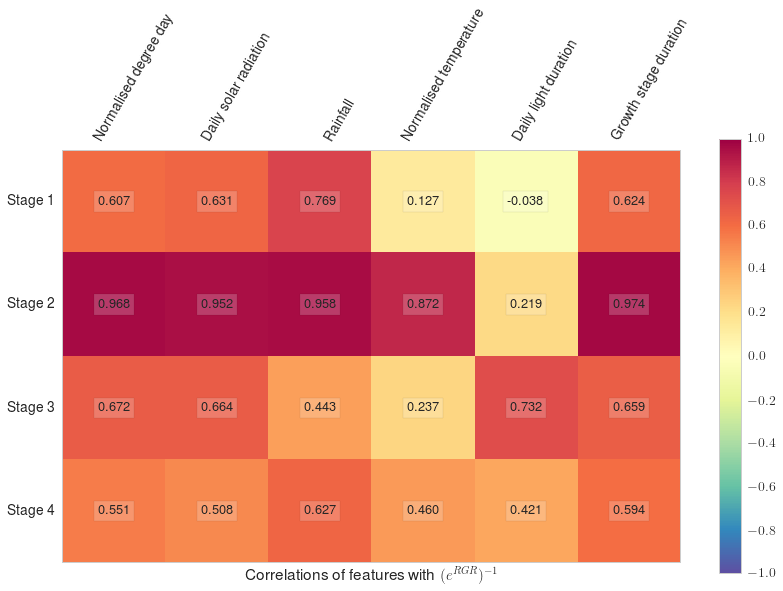

In [21]:
# Plot the correlations betwee the feature vectors and the RGRs

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cax = ax.matshow(rgr_rcorrs_3day, cmap=cm.Spectral_r, vmin=-1.0, vmax=1.0)
ax.set_xticks(np.arange(len(colss)) + 0.2)
ax.set_xticklabels(colss, rotation=60)
ax.set_yticks(range(4))
ax.set_yticklabels(["Stage {}".format(i) for  i in range(1, 5)])
ax.set_xlabel(r'Correlations of features with $(e^{RGR})^{-1}$')
ax.grid('off')

m, n = rgr_rcorrs_3day.shape
for row in range(m):
    for col in range(n):
        ax.annotate("{:.03f}".format(rgr_rcorrs_3day[row, col], 3), xy=(col, row), 
                    fontsize=13, ha='center', va='center', bbox=dict(alpha=0.2, fc='white'))

fig.colorbar(cax)
plt.tight_layout()

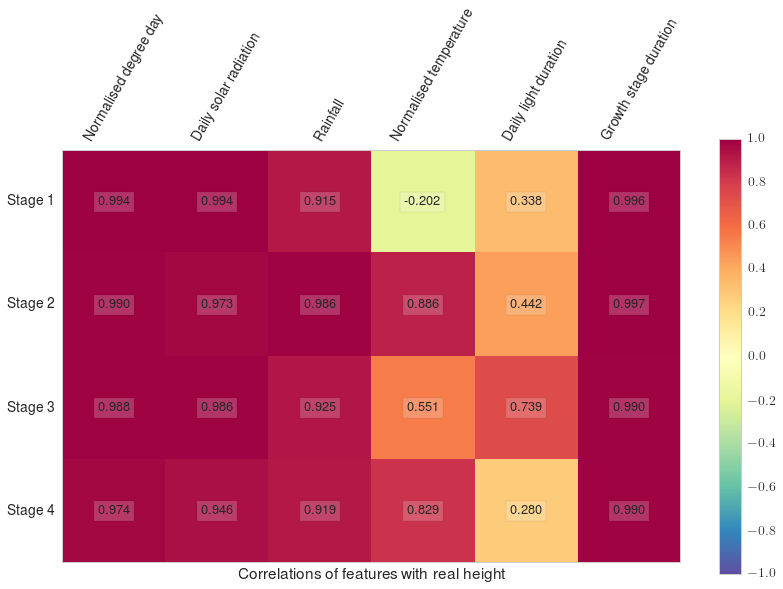

In [22]:
# Plot the correlations between the envrionmental features and the real height

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cax = ax.matshow(rh_rcorrs_3day, cmap=cm.Spectral_r, vmin=-1.0, vmax=1.0)
ax.set_xticks(np.arange(len(colss)) + 0.1)
ax.set_xticklabels(colss, rotation=60)
ax.set_yticks(range(4))
ax.set_yticklabels(["Stage {}".format(i) for  i in range(1, 5)])
ax.set_xlabel('Correlations of features with real height')
ax.grid('off')

m, n = rh_rcorrs_3day.shape
for row in range(m):
    for col in range(n):
        ax.annotate("{:.03f}".format(rh_rcorrs_3day[row, col], 3), xy=(col, row), 
                    fontsize=13, ha='center', va='center', bbox=dict(alpha=0.2, fc='white'))

fig.colorbar(cax)
plt.tight_layout()

In [23]:
# Turn of latex printing as we no longer require it.
rc('text', usetex=False)

In [24]:
ohe = OneHotEncoder()
ohe.fit(np.arange(1, 7).reshape(-1, 1))

# An example One-hot encoding is shown below for the growth stages: 1, 4, and 5
example_stages = np.array([[1, 4, 5]]).T 
print ohe.transform(example_stages).toarray()

[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]]


In [25]:
all_X = []
all_y = []

print "Processing..."

for ax_idx, geno in enumerate(start_values.Genotype.tolist()):
    if geno == 'GT':
        continue
    
    print "\t{}".format(geno)
    
    geno_real_height = df[df.Genotype == geno].Real_Height.as_matrix()
    geno_rgr3 = get_rgr(geno_real_height, 3)
    
    geno_features = feas_3days[genotype == geno]
    
    # Get the rolling three day features
    ThermU_Day_Sum3 = rolling_window(geno_features.ThermU_Day, 3).sum(axis=1).cumsum()
    SolarRadi_Day_Sum3 = rolling_window(geno_features.SolarRadi_Day, 3).sum(axis=1).cumsum()
    Rain_Sum3 = rolling_window(geno_features.Rain, 3).sum(axis=1).cumsum()
    
    ThermU_Day_Avg3 = rolling_mean(geno_features.ThermU_Day, 3)[2:]
    Avg_Temp_Avg3 = rolling_mean(geno_features.Avg_Temp, 3)[2:]
    Light_Dur_Day_Avg3 = rolling_mean(geno_features.Light_Dur_Day, 3)[2:]
    AVG_LightInt_Day_Avg3 = rolling_mean(geno_features.AVG_LightInt_Day, 3)[2:]
    
    GS_Days_normal = geno_features.GS_Days.as_matrix()[2:]

    # Extract the features from each stage
    for st in stages:
        mask = (df.Grow_Stg == st)[df.Genotype == geno][3:].as_matrix()
        currX = np.vstack([
            ThermU_Day_Sum3[mask],
            SolarRadi_Day_Sum3[mask],
            Rain_Sum3[mask],
            #ThermU_Day_Avg3[mask],
            Avg_Temp_Avg3[mask],
            Light_Dur_Day_Avg3[mask],
            #AVG_LightInt_Day_Avg3[mask],
            GS_Days_normal[mask]
        ]).T
               
        # Get the stage information encoded as a one-hot vector
        geno_st_lbl = ohe.transform((np.ones(geno_rgr3[mask].shape) * st).reshape(-1, 1)).toarray()
        
        all_X.append(np.hstack([currX, geno_st_lbl]))
        all_y.append(geno_rgr3[mask])
    
X = np.vstack(all_X)
y = np.concatenate(all_y)

Processing...
	G1
	G2
	G3
	G4
	G5


In [26]:
# Apply z-score normalisation to the environmental features, and not the
# one-hot encoded growth stages as they are already suitably encoded.
ss = StandardScaler()
X[:, :-6] = ss.fit_transform(X[:, :-6])

# Produce a linear regression model from the input environmental features
# and the relative growth rate.
lr = LinearRegression(normalize=True)
lr.fit(X, y.reshape(-1, 1))

# Show the model coefficients.
print np.round(lr.coef_, 6).ravel().tolist()

[0.125948, -0.133118, -0.011052, 0.001833, -0.012666, -0.024696, 0.018912, 0.029993, 0.010367, -0.000427, -0.01003, -0.030327]


Genotype: G1	MSE: 193.4761	Correlation: 0.9942
Genotype: G2	MSE: 29.4404	Correlation: 0.9963
Genotype: G3	MSE: 14.4299	Correlation: 0.9774
Genotype: G4	MSE: 19.3057	Correlation: 0.9944
Genotype: G5	MSE: 817.5295	Correlation: 0.9875
Genotype: GT	MSE: 20.1512	Correlation: 0.9991


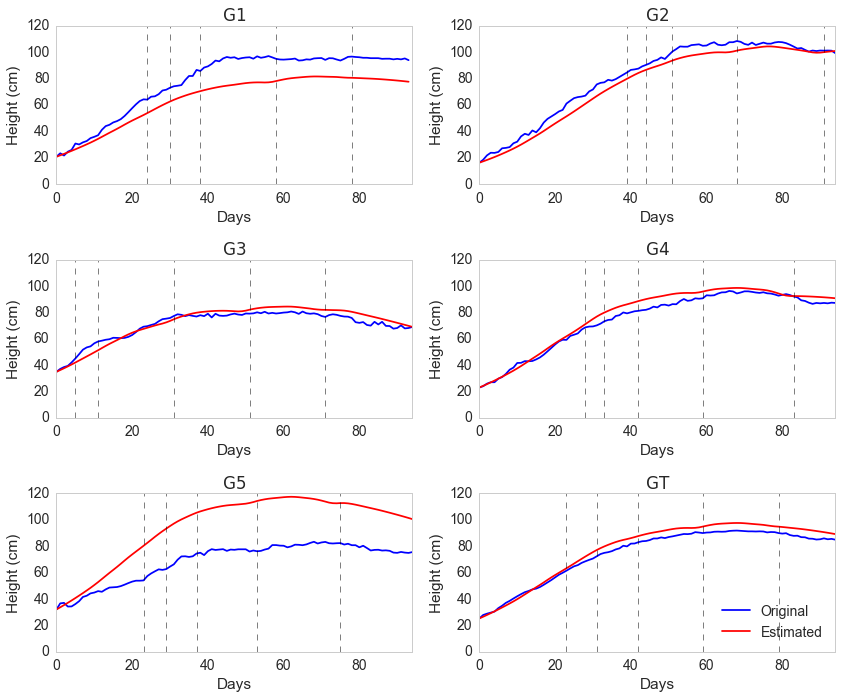

In [31]:
fig, axarr = plt.subplots(3, 2, figsize=(12, 10)) #, sharex=True, sharey=True)
axarr = axarr.flat

GT_real_height = df[df.Genotype == 'GT'].Real_Height.as_matrix()

for ax_idx, geno in enumerate(start_values.Genotype.tolist()):
    
    geno_real_height = df[df.Genotype == geno].Real_Height.as_matrix()
    
    start = geno_real_height[0]
    
    geno_rgr3 = get_rgr(geno_real_height, 3)
    
    geno_features = feas_3days[genotype == geno]
    
    #Get the three day rolling features
    ThermU_Day_Sum3 = rolling_window(geno_features.ThermU_Day, 3).sum(axis=1).cumsum()
    SolarRadi_Day_Sum3 = rolling_window(geno_features.SolarRadi_Day, 3).sum(axis=1).cumsum()
    Rain_Sum3 = rolling_window(geno_features.Rain, 3).sum(axis=1).cumsum()
    
    ThermU_Day_Avg3 = rolling_mean(geno_features.ThermU_Day, 3)[2:]
    Avg_Temp_Avg3 = rolling_mean(geno_features.Avg_Temp, 3)[2:]
    Light_Dur_Day_Avg3 = rolling_mean(geno_features.Light_Dur_Day, 3)[2:]
    AVG_LightInt_Day_Avg3 = rolling_mean(geno_features.AVG_LightInt_Day, 3)[2:]
    
    GS_Days_normal = geno_features.GS_Days.as_matrix()[2:]

    #print GS_Days_normal[:5]    
    rgr_pred = []
    
    for st in stages:
        mask = (df.Grow_Stg == st)[df.Genotype == geno][3:].as_matrix()
        
        # Produce the current genotype/stage feature vector
        currX = np.vstack([
            ThermU_Day_Sum3[mask],
            SolarRadi_Day_Sum3[mask],
            Rain_Sum3[mask],
            #ThermU_Day_Avg3[mask],
            Avg_Temp_Avg3[mask],
            Light_Dur_Day_Avg3[mask],
            #AVG_LightInt_Day_Avg3[mask],
            GS_Days_normal[mask]
        ]).T
        
        geno_st_lbl = ohe.transform((np.ones(geno_rgr3[mask].shape) * st).reshape(-1, 1)).toarray()
        
        # Produce joint feature vector with one-hot encoding and z-scored environmental features
        currX = np.hstack([ss.transform(currX), geno_st_lbl])
        rgr_pred.append(lr.predict(currX))
        
    rgr_pred = np.concatenate(rgr_pred)
    rgr_pred_nan = np.tile(np.nan, (rgr_pred.shape[0], geno_real_height.shape[0]))
    
    # Get the real height using the start height and the estimated RGR values
    for pos, row in enumerate(rgr_pred):
        rgr_pred_nan[pos, pos:pos+3] = np.ones((1, 3)) * (row / 3.)
        
    rgr_pred = np.nanmean(rgr_pred_nan, axis=0)
    
    out = [start]
    for idx, per in enumerate(rgr_pred):
        out.append(out[idx] * (1 + per))
        
    # For plotting the stage boundaries on the below graph.
    stg_lines = [np.argmax(df.Grow_Stg[df.Genotype == geno].as_matrix() == i) for i in stages[1:]]
        
    axarr[ax_idx].set_title(geno)
    axarr[ax_idx].plot(geno_real_height, 'b', label='Original')
    axarr[ax_idx].plot(out, 'r', label='Estimated')
    axarr[ax_idx].set_xlabel("Days")
    axarr[ax_idx].set_xlim([0, 94])
    axarr[ax_idx].set_ylabel("Height (cm)")
    
    for pt in stg_lines:
        axarr[ax_idx].plot([pt, pt], [0, 120], 'k--', linewidth=1, alpha=0.5)
    
    axarr[ax_idx].grid('off')
    
    # Calculate MSE, and r, and print for each genotype
    mse = metrics.mean_squared_error(geno_real_height, out[:-1])
    r = rcorr(geno_real_height, out[:-1])
    print "Genotype: {}\tMSE: {:.4f}\tCorrelation: {:.4f}".format(geno, mse, r)
    
axarr[5].legend(loc="lower right")

plt.tight_layout()